In [1]:
import sys
sys.path.append('../../')

import pandas as pd

df = pd.read_parquet('../../out/parquet/t5-base_inference_4.parquet')

df

,X,y,y_pred,failed_score,completed_score
16,"On April 30 2023 the value of ""Walk at least 1...",COMPLETED,COMPLETED,0.249997,0.999164
17,"On April 30 2023 the value of ""Collect at leas...",FAILED,COMPLETED,0.249993,0.999667
18,"On April 30 2023 the value of ""Bike at least 3...",COMPLETED,COMPLETED,0.249429,0.998824
19,"On April 30 2023 the value of ""Collect at leas...",FAILED,COMPLETED,0.249983,0.999513
20,"On April 30 2023 the value of ""Walk at least 1...",COMPLETED,COMPLETED,0.249933,0.995097
...,...,...,...,...,...
6011,"On August 27 2023 the value of ""Bike at least ...",COMPLETED,COMPLETED,0.250620,0.999373
6012,"On August 27 2023 the value of ""Bike at least ...",COMPLETED,COMPLETED,0.250149,0.999850
6013,"On August 27 2023 the value of ""Walk at least ...",COMPLETED,FAILED,0.999154,0.250838
6014,"On August 27 2023 the value of ""Walk at least ...",COMPLETED,FAILED,0.977422,0.272547


In [2]:
X = df[['completed_score', 'failed_score']]
y = df['y']

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

scaler = StandardScaler()
le = LabelEncoder()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = torch.LongTensor(y_train)
X_test = Variable(torch.from_numpy(X_test)).float()
y_test = torch.LongTensor(y_test)

print(le.classes_)

['COMPLETED' 'FAILED']


In [4]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_size, output_size):
        super(MLP, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList()
        for _ in range(hidden_layers):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = F.relu(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))
        x = self.output_layer(x)
        return x

In [5]:
ffn = MLP(
    input_size=X_train.shape[1],
    hidden_layers=4,
    hidden_size=256,
    output_size=len(le.classes_)
)

optimizer = torch.optim.Adam(ffn.parameters(), lr=0.001)

weights = torch.tensor([1 - c/sum(y_train.bincount()) for c in y_train.bincount()])
criterion = nn.CrossEntropyLoss(weight=weights)
ffn

MLP(
  (input_layer): Linear(in_features=2, out_features=256, bias=True)
  (hidden_layers): ModuleList(
    (0-3): 4 x Linear(in_features=256, out_features=256, bias=True)
  )
  (output_layer): Linear(in_features=256, out_features=2, bias=True)
)

In [6]:
def epoch(X, y, model, criterion, optimizer):
    outputs = model(X)
    loss = criterion(outputs, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    test_outputs = ffn(X_test)
    test_loss = criterion(test_outputs, y_test)
    
    return loss, test_loss

epochs = 1000
for i in range(epochs):
    loss, test_loss = epoch(X_train, y_train, ffn, criterion, optimizer)

    if i % 100 == 0:
        print(f'Epoch: {i} Loss: {loss.item()} Test Loss: {test_loss.item()}')
    

Epoch: 0 Loss: 0.6926055550575256 Test Loss: 0.6773359179496765
Epoch: 100 Loss: 0.5067909955978394 Test Loss: 0.5069810748100281
Epoch: 200 Loss: 0.4990978240966797 Test Loss: 0.49337056279182434
Epoch: 300 Loss: 0.49723494052886963 Test Loss: 0.49392300844192505
Epoch: 400 Loss: 0.49639636278152466 Test Loss: 0.4945835769176483
Epoch: 500 Loss: 0.4972238540649414 Test Loss: 0.49665141105651855
Epoch: 600 Loss: 0.4968838393688202 Test Loss: 0.49155157804489136
Epoch: 700 Loss: 0.49786239862442017 Test Loss: 0.4914731979370117
Epoch: 800 Loss: 0.49653905630111694 Test Loss: 0.49563097953796387
Epoch: 900 Loss: 0.4971194565296173 Test Loss: 0.49372121691703796


In [7]:
from scipy.special import softmax

X_val = scaler.transform(X)

X_val = Variable(torch.from_numpy(X_val)).float()

logits = ffn(X_val)
logits = logits.detach().numpy()

Y_hat = np.argmax(logits, axis=1)
Y_hat = le.inverse_transform(Y_hat)

probs = pd.DataFrame(softmax(logits, axis=1), columns=le.classes_)

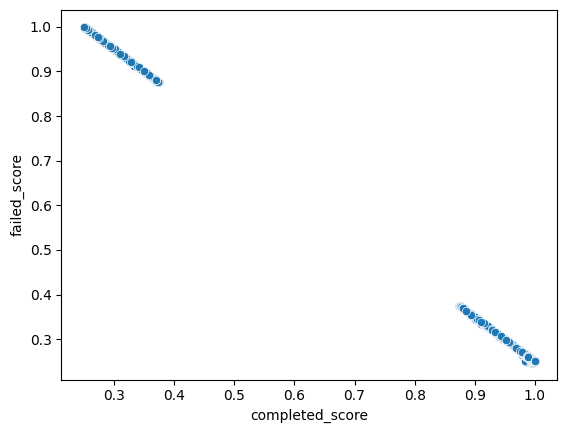

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt


sns.scatterplot(x='completed_score', y='failed_score', data=df)
plt.show()

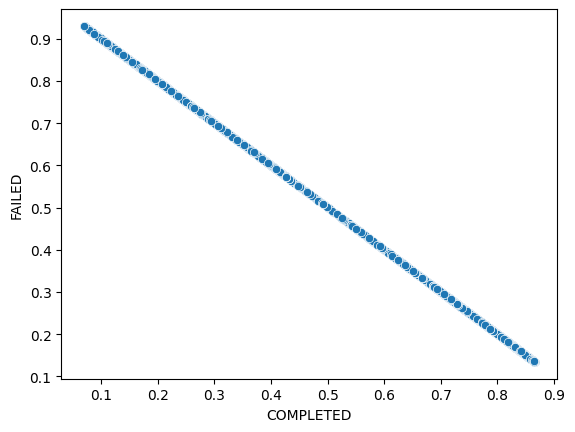

In [9]:
sns.scatterplot(x='COMPLETED', y='FAILED', data=probs)
plt.show()

In [10]:
from src.utils import metrics_scores

print('MLP: ', metrics_scores(df['y'], Y_hat, pos_label='COMPLETED'))
print('ORIGINAL: ', metrics_scores(df['y'], df['y_pred'], pos_label='COMPLETED'))

MLP:  {'accuracy': 0.783, 'precision': 0.7117082533589252, 'recall': 0.7708939708939709, 'f1': 0.7401197604790419}
ORIGINAL:  {'accuracy': 0.7796666666666666, 'precision': 0.7305236270753512, 'recall': 0.7135135135135136, 'f1': 0.7219183845183004}


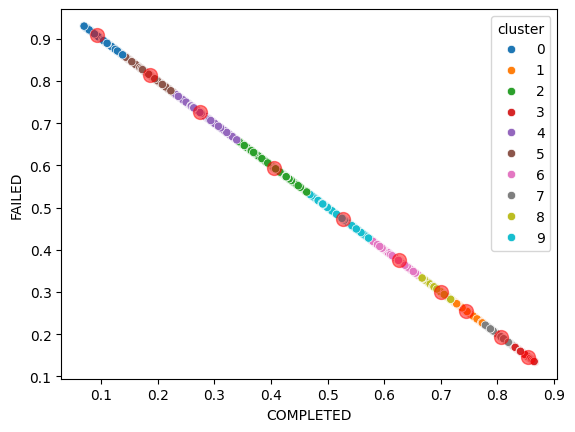

In [11]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(probs)

probs['cluster'] = kmeans.labels_

sns.scatterplot(x='COMPLETED', y='FAILED', data=probs, hue='cluster', palette='tab10')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=100, alpha=0.5)

plt.show()